In [1]:
!pip install gdown

In [2]:
import gdown
url = 'https://drive.google.com/file/d/1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-/view?usp=sharing'
output_path = '/kaggle/working/pre_data.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

import zipfile
extract_dir = '/kaggle/working/'

with zipfile.ZipFile('/kaggle/working/pre_data.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-
From (redirected): https://drive.google.com/uc?id=1KCKfyIGbQi8a7bIYta3LM8dFStxVzVX-&confirm=t&uuid=743684b6-91ce-4303-8ff5-05b58c66d614
To: /kaggle/working/pre_data.zip
100%|██████████| 1.78G/1.78G [00:21<00:00, 80.8MB/s]


In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import metrics

In [4]:
# Constants
IMG_SIZE = (64, 64)  # You can adjust this as needed
NUM_FRAMES = 20  # Number of frames per video
CATEGORIES = ["non shop lifters", "shop lifters"]
# CATEGORIES_ENC = [1, 0]

In [5]:
# Function to process videos into frames
def process_video(video_path, img_size=IMG_SIZE, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
    cap.release()
    
    # If fewer frames than required, pad with copies of the last frame
    while len(frames) < num_frames:
        frames.append(frames[-1])
    
    return np.array(frames)

In [6]:
# Load dataset
def load_dataset(base_dir):
    data = []
    labels = []
    
    for category in CATEGORIES:
        folder_path = os.path.join(base_dir, category)
        class_num = CATEGORIES.index(category)
        
        for video in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video)
            video_frames = process_video(video_path)
            data.append(video_frames)
            labels.append(class_num)
    
    # Convert to NumPy arrays
    data = np.array(data)
    labels = to_categorical(labels, num_classes=len(CATEGORIES))
    
    return data, labels

# Example usage
data, labels = load_dataset("/kaggle/working/Shop DataSet")

In [7]:
data.shape

(855, 20, 64, 64, 3)

In [8]:
sum(labels == [0., 1.])

array([324, 324])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42) 

In [32]:


# Define 3D CNN model
def create_model(input_shape=(NUM_FRAMES, IMG_SIZE[0], IMG_SIZE[1], 3)):
    model = Sequential()
    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))  # 2 classes: non-shop lifters, shop lifters
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_model()



In [33]:
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.5205 - loss: 162.1471 - val_accuracy: 0.6496 - val_loss: 0.5538
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8423 - loss: 0.3447 - val_accuracy: 0.9197 - val_loss: 0.2833
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9339 - loss: 0.1580 - val_accuracy: 0.9489 - val_loss: 0.1988
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9256 - loss: 0.1728 - val_accuracy: 0.8759 - val_loss: 0.3235
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9562 - loss: 0.1164 - val_accuracy: 1.0000 - val_loss: 0.0573
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9879 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9817 - loss: 0.0584 - val_accuracy: 0.9854 - val_loss: 0.0516
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9725 - loss: 0.0652 - val_accuracy: 1.0000

In [34]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'test loss: {test_loss}')
print(f'test accuracy: {test_acc}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 5.0669e-04
test loss: 0.0005647761281579733
test accuracy: 1.0


In [36]:
model.save('Video clf.keras')

In [37]:
model = load_model("Video clf.keras")

In [38]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [39]:
y_test = y_test[:, 0]

In [40]:
y_test = np.expand_dims(y_test, axis=0).reshape(-1, 1)
y_test

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],

In [41]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [42]:
y_pred = y_pred[:, 0]

In [43]:
y_pred = np.expand_dims(y_pred, axis=0).reshape(-1, 1) >= 0.5
y_pred

array([[ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [

In [44]:
import pandas as pd
cm = confusion_matrix(y_test, y_pred)

In [45]:
cm

array([[ 65,   0],
       [  0, 106]])

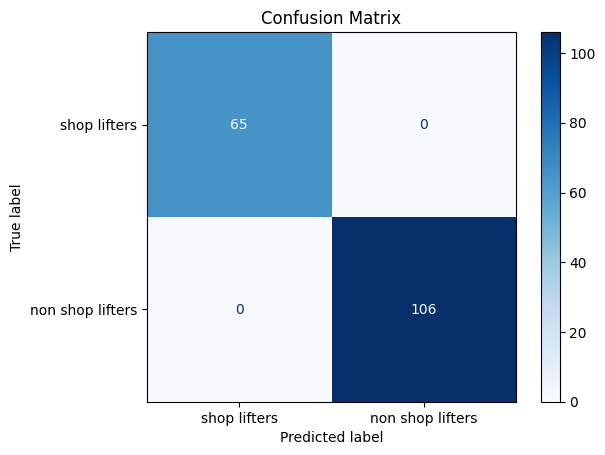

In [46]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.xticks([1, 0], ["non shop lifters", "shop lifters"])
plt.yticks([1, 0], ["non shop lifters", "shop lifters"])
# You can choose different color maps
plt.title('Confusion Matrix')
plt.show()

In [47]:
sum(y_pred - y_test)

array([0.])

In [48]:
sum(y_test)

array([106.])

In [49]:
sum(y_pred)

array([106])

In [51]:
y_test[0]

array([1.])